파이토치로 best_cnn_model.pth(가중치)를 불러와보자!\
파이토치는 가중치만 가능

In [1]:
import torch
import torch.nn as nn

In [2]:
model = nn.Sequential()

# 합성곱 층 1
model.add_module("conv1", nn.Conv2d(1, 32, 3, padding='same'))
model.add_module("relu1", nn.ReLU())  # 풀링 전에 활성화 함수 설정하는 것을 잊지 말자!
                                      # - 활성화 함수까지 통과 시키고 나서야 특성맵이 만들어진다
model.add_module("pool1", nn.MaxPool2d(2))

# 합성곱 층 2
model.add_module("conv2", nn.Conv2d(32, 64, 3, padding='same'))
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(2))

# Flatten 층
model.add_module('flatten', nn.Flatten())

# 은닉층 입력 크기 확인
outputs = model(torch.ones(1, 1, 28, 28))  # 가짜 데이터를 넣어서 입력 데이터가 몇 개인지 확인
print(outputs.shape)  # torch.Size([1, 3136]) -> 3136개

# 은닉층
model.add_module('dense1', nn.Linear(7 * 7 * 64, 100))  # 3136, 100
model.add_module("relu3", nn.ReLU())
model.add_module("dropout", nn.Dropout(0.3))

# 출력층
model.add_module("dense2", nn.Linear(100, 10))

torch.Size([1, 3136])


In [3]:
model.load_state_dict(torch.load('best_cnn_model.pth', weights_only=True))

<All keys matched successfully>

#### 모델의 층 목록을 확인해보자
방법1) `.children()`: generate 객체, 모든 층의 정보를 반환한다.

방법2) `.층_이름`: 해당 이름을 가진 층의 정보 반환

방법3) `model.named_children()`: 튜플 반환 -> (층_이름, 층_객체)

In [ ]:
# 방법 1
layers = [layer for layer in model.children()]
layers

[Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=3136, out_features=100, bias=True),
 ReLU(),
 Dropout(p=0.3, inplace=False),
 Linear(in_features=100, out_features=10, bias=True)]

In [ ]:
# 방법 2
model.conv1

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [ ]:
# 방법 3
for name, layer in model.named_children():
    print("name:", name, "layer:", layer)

name: conv1 layer: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
name: relu1 layer: ReLU()
name: pool1 layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
name: conv2 layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
name: relu2 layer: ReLU()
name: pool2 layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
name: flatten layer: Flatten(start_dim=1, end_dim=-1)
name: dense1 layer: Linear(in_features=3136, out_features=100, bias=True)
name: relu3 layer: ReLU()
name: dropout layer: Dropout(p=0.3, inplace=False)
name: dense2 layer: Linear(in_features=100, out_features=10, bias=True)


#### 특성맵 시각화
- ex01.ipynb에서 했던 것
- 첫 번째 Conv 층을 통과한 특성맵

In [ ]:
# Fashion MNIST 데이터셋 불러오기
from torchvision.datasets import FashionMNIST
fm_train = FashionMNIST(root='.', train=True, download=True)

# 이미지 입력 - 채널 명시 (배치, 채널, 높이, 너비)
train_input = fm_train.data

100%|██████████| 26.4M/26.4M [00:04<00:00, 6.52MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 126kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 2.19MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [9]:
# .reshape(배치_크기, 채널_수, 높이, 너비)
# -> .reshape(1, 1, 28, 28)
# -> 1장의 흑백 이미지(28x28)를 배치에 넣을 수 있게 4차원으로 변환한 것
ankle_boot = train_input[0].reshape(1, 1, 28, 28) / 255.0

In [ ]:
# 모델을 평가 모드로 전환 (Dropout, BatchNorm 등 비활성화)
model.eval()
with torch.no_grad():  # 그래디언트 계산 비활성화 (추론 시 불필요한 연산 방지)
    feature_maps = model.conv1(ankle_boot)
    feature_maps = model.relu1(feature_maps)

feature_maps.shape

torch.Size([1, 32, 28, 28])

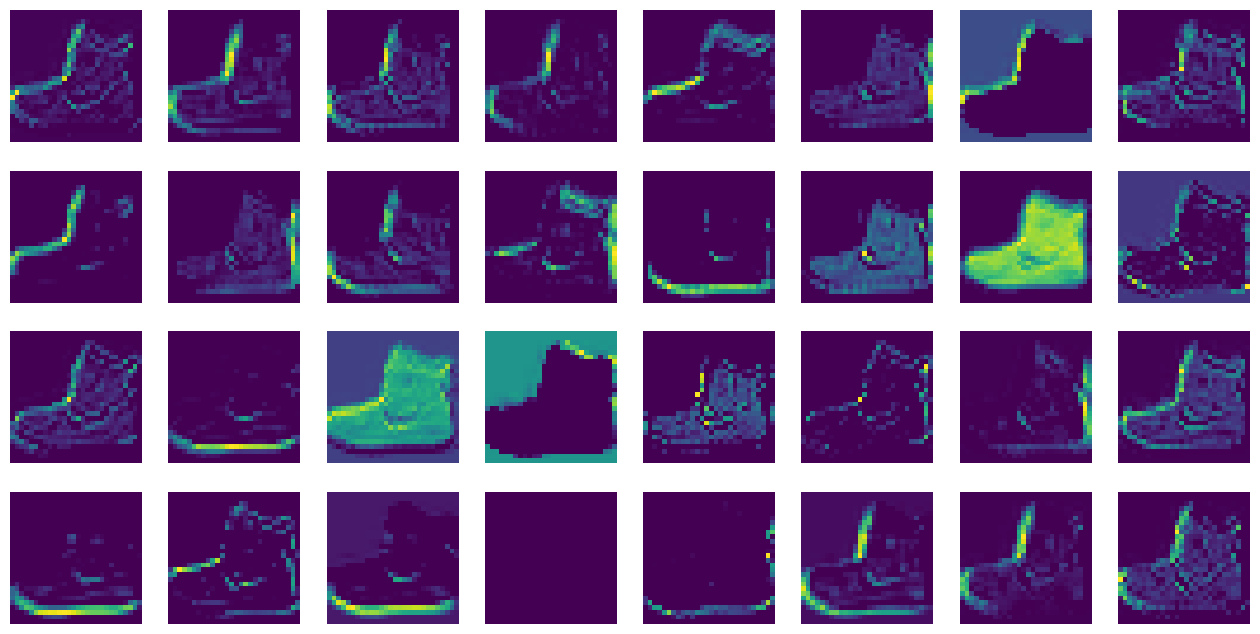

In [14]:
import matplotlib.pyplot as plt

# 4행 8열의 서브플롯 생성 (총 32개), 전체 그림 크기를 (16인치, 8인치)로 설정
_, axs = plt.subplots(4, 8, figsize=(16, 8))

# 32개의 feature map을 4행 8열 격자로 시각화
for i in range(4):
    for j in range(8):
        # feature_maps[0, k, :, :]에서 k번째 채널의 특성 맵 시각화
        axs[i, j].imshow(feature_maps[0, i * 8 + j, :, :])
        axs[i, j].axis('off')  # 축(눈금과 라벨) 제거
    
plt.show()

#### 특성맵 시각화
- 두 번째 Conv 층을 통과한 특성맵 64

In [ ]:
model.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 등 비활성화)

with torch.no_grad():  # 그래디언트 계산 비활성화 (추론 시 불필요한 연산 방지)
    feature_maps = model.conv1(ankle_boot)      # 첫 번째 합성곱 계층(conv1)을 통과 → 32개 채널로 변환
    feature_maps = model.relu1(feature_maps)    # ReLU 활성화 함수 적용 → 비선형성 부여
    feature_maps = model.pool1(feature_maps)    # MaxPooling 적용 → 공간 축소 (28x28 → 14x14)
    feature_maps = model.conv2(feature_maps)    # 두 번째 합성곱 계층(conv2)을 통과 → 64개 채널로 변환
    feature_maps = model.relu2(feature_maps)    # ReLU 활성화 함수 적용 → 최종 feature map 생성


feature_maps.shape

torch.Size([1, 64, 14, 14])

In [19]:
model.eval()  # 평가

x = ankle_boot

with torch.no_grad():
    for name, layer in model.named_children():
        x = layer(x)
        if name == 'relu2':
            break

feature_maps = x

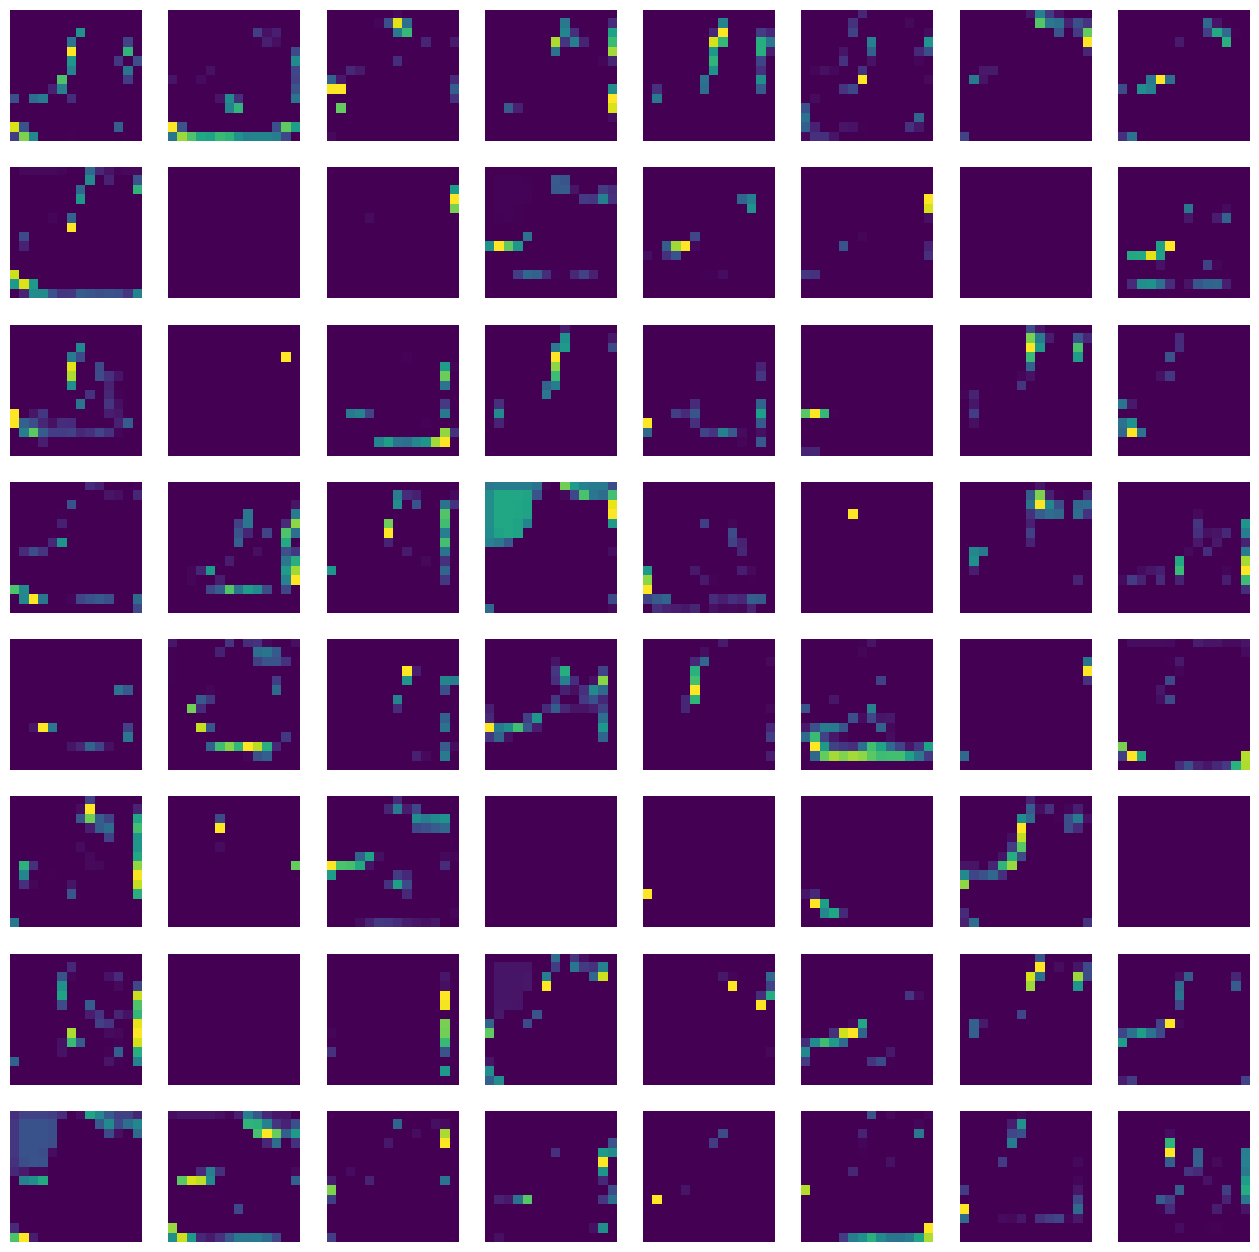

In [20]:
# 8행 8열의 서브플롯 생성 (총 64개), 전체 그림 크기를 (16인치, 16인치)로 설정
_, axs = plt.subplots(8, 8, figsize=(16, 16))

# 32개의 feature map을 8행 8열 격자로 시각화
for i in range(8):
    for j in range(8):
        # feature_maps[0, k, :, :]에서 k번째 채널의 특성 맵 시각화
        axs[i, j].imshow(feature_maps[0, i * 8 + j, :, :])
        axs[i, j].axis('off')  # 축(눈금과 라벨) 제거
    
plt.show()

# LeNet-5 (1998, Yann LeCun)
- 활성화 함수: Sigmoid
- 풀링 방식: AveragePooling(평균 풀링) 사용
- 얕은 구조, 손글씨(MNIST) 인식에 사용
※ ImageNet 대회 이전 (참고: ImageNet 대회는 2010~2017년에 열림)

# AlexNet (2012, ImageNet 대회 우승)
- 활성화 함수: ReLU 도입
- 풀링 방식: MaxPooling(최대 풀링)
- 정규화 기법: Dropout 사용
  - 완전 연결층(Dense Layer)에서 일부 유닛을 랜덤하게 끔 → 과적합 방지
- GPU 병렬 처리로 대규모 이미지 분류 도전

# VGGNet-16 모델 (2014, ImageNet 대회 준우승)
- 기존 "합성곱층 → 풀링층 → 합성곱층 → 풀링층" 구조 ⟶ "합성곱층 x n → 풀링층" 구조로 재구성
- 네트워크는 **블록 단위**로 구성\
: "(3x3 합성곱 x n회) → MaxPooling" 형태 반복
- 하나의 큰 필터(7x7, 5x5)를 사용 ⟶ 여러 개의 3x3 작은 필터를 연속으로 사용\
: <span style="color:limegreen"><b>파라미터 수 절약</b></span>, 비선형성 더 많이 삽입 → 표현력과 성능 향상

[VGGNet 예제 바로가기](vggnet.ipynb)<br>
<span style="font-size:13px">강아지 이미지 결과 - ('n02099712', 'Labrador_retriever', np.float32(0.35698158))</span><br>
<span style="font-size:13px">고양이 이미지 결과 - ('n02123045', 'tabby', np.float32(0.43275306))</span>

> 📌 <span style="color:limegreen"><b>파라미터 수를 줄이는 것</b></span>은 속도와 효율 면에서 매우 중요해짐.

# GoogLeNet (2014, ImageNet 대회 우승)
- **Inception 모듈** 도입\
  → 서로 다른 크기의 커널(1x1, 3x3, 5x5)을 병렬 적용하여 다양한 특징 추출
- 연산 효율 높이고, 파라미터 수를 줄이면서도 높은 성능 확보

# ResNet (2015, ImageNet 대회 우승)
- 잔차 블록 (Residual Block 또는 Skip Block) 도입 → 정보 전달 경로 보장
  - 입력을 출력에 그대로 더하는 **스킵 연결(Skip Connection)**을 통해, 신경망이 입력과 출력의 차이(잔차, Residual)를 학습하도록 유도.
  - 이를 통해 정보가 층을 건너뛰며 전달되므로, 깊은 네트워크에서도 학습이 잘 이루어짐.
  - **유용한 특징이 층을 거치며 왜곡되거나 약해지는 것**을 막아줌.
- 활성화 함수: ReLU
- 정규화 기법: 배치 정규화 (Batch Normalization)
  - 학습 도중 각 층의 입력 분포가 계속 변하는 문제(Internal Covariate Shift)를 완화.
  - 전체 데이터가 아닌, **미니배치 단위**로 정규화 수행. (학습 도중에 정규화)
  - 학습 속도 ↑, 과적합 ↓
- Flatten 대신 GlobalAveragePooling2D 사용\
  → <span style="color:limegreen"><b>파라미터 감소</b></span>, 과적합 방지

# DenseNet
- ResNet의 확장 모델
- 모든 이전 층의 출력을 현재 층에 직접 연결 (밀집 연결)
- 파라미터 효율 + 정보 흐름 개선

# MobileNet (2017~) - 모바일 환경(경량) 모델
- 경량 모델 (모바일/임베디드 최적화)
- Depthwise Separable Convolution 사용\
  → 깊이별 합성곱 + 점별 합성곱
- 연산량↓, 속도↑, 경량화(파라미터 수 축소)에 초점

# EfficientNet (2019, Google) ✨
- **Compound Scaling**: 모델의 깊이(depth), 너비(width), 해상도(resolution)를 **균형 있게** 조절
- 활성화 함수: **Swish(스위시) 함수** 사용 (ReLU보다 부드럽고 성능 우수)
- 높은 정확도 + 낮은 연산량 (SOTA 효율 달성)

[EfficientNet 예제 (1) 바로가기](efficientnet1.ipynb)<br>
<span style="font-size:13px">강아지 이미지 결과 - ('n02099712', 'Labrador_retriever', np.float32(0.3682936))</span><br>
<span style="font-size:13px">고양이 이미지 결과 - ('n02124075', 'Egyptian_cat', np.float32(0.35218692))</span>

[EfficientNet 예제 (2) 바로가기](efficientnet1.ipynb)<br>
<span style="font-size:13px">피스타치오 이미지 결과 - ('n01955084', 'chiton', np.float32(0.25582632))</span>